# [Amazon Locker Capacity Management](https://doi.org/10.1287/inte.2023.0005)

- **Course:** MSCI 434
- **Team:** 1

### Overview

Amazon Locker, a self-service delivery and pickup system, faces a capacity issue where standard shipping packages fill lockers, leaving no space for expedited packages.

### Required Libraries
- !pip install gurobipy
- !pip install numpy
- !pip install matplotlib

# Paper Model Implentation

In [16]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np

In [12]:
def run_model(T,S, C, p, e, d):
    model = gp.Model('AmazonLockerOptimization')

    # Decision Variables

    # x = the number of slots to reserve for shipoption s on day t
    x = model.addVars(S, T, vtype=GRB.CONTINUOUS, name="x")
    
    # y = the number of packages accepted for arrival for ship options s on day t
    y = model.addVars(S, T, vtype=GRB.CONTINUOUS, name="y")

    # Objective Function (A.1)
    model.setObjective(gp.quicksum(y[s, t] for s in range(S) for t in range(T)), GRB.MAXIMIZE)

    # Constraint (A.2): Ensure locker capacity is not violated
    for t in range(T):
        model.addConstr(
            gp.quicksum(p[s][v][t] * y[s, v] for s in range(S) for v in range(t+1)) +
            gp.quicksum(p[s][v][t] * e[s][v] for s in range(S) for v in range(-6, 1)) <= C
        )

    # Constraint (A.3): Number of packages accepted must be less than or equal to the demand
    for s in range(S):
        for t in range(T):
            model.addConstr(y[s, t] <= d[s][t])

    # Constraint (A.4): Relationship between number of packages accepted and slots reserved
    for s in range(S):
        for t in range(T):
            model.addConstr(
                gp.quicksum(p[s][v][t] * y[s, v] for v in range(t+1)) +
                gp.quicksum(p[s][v][t] * e[s][v] for v in range(-6, 1)) == x[s, t]
            )

    # Constraint (A.5): Non-negativity of decision variables
    for s in range(S):
        for t in range(T):
            model.addConstr(x[s, t] >= 0)
            model.addConstr(y[s, t] >= 0)

    model.optimize()
    
    return model

## Model Parameters

In [13]:
capacities = [1,2,3,4,5,6,7,8,9,10, 20, 30, 40, 50, 60 ,70, 80 ,90, 100, 200, 300, 400]
results = {}

np.random.seed(42)  

# Parameters
T = 7  # Planning horizon (days)
S = 2  # Number of shipping options (standard, two-day)

# Generate random dwell time probabilities
p_standard = [np.clip(np.random.normal(1.1, 0.2, T), 0, None).tolist() for _ in range(-6, T)]
p_two_day = [np.clip(np.random.normal(0.75, 0.1, T), 0, None).tolist() for _ in range(-6, T)]
p = [p_standard, p_two_day]

# Generate random initial packages in locker at the end of day 0
e_standard = np.random.randint(0, 2, size=7).tolist()
e_two_day = np.random.randint(0, 2, size=7).tolist()
e = [e_standard, e_two_day]

# Package demand forecast
ratio_of_standard_to_two_day = 0.075 # approximate average ratio from Figure 3 (weeks 14 to 23)
num_packages_delivered = [28, 39, 33, 47, 34, 44, 32] # Figure 5 demands from April 15 to April 21
d_standard = np.round((1 - ratio_of_standard_to_two_day) * np.array(num_packages_delivered)).astype(int)
d_two_day = np.round(ratio_of_standard_to_two_day * np.array(num_packages_delivered)).astype(int)

# Adjust the rounded values to sum to num_packages_delivered
for i in range(len(num_packages_delivered)):
    while d_standard[i] + d_two_day[i] < num_packages_delivered[i]:
        d_standard[i] += 1
    while d_standard[i] + d_two_day[i] > num_packages_delivered[i]:
        d_two_day[i] -= 1

d = [d_standard, d_two_day]

## Run Model

In [14]:
throughputs = []
for C in capacities:
    result = run_model(T, S, C, p, e, d)
    results[C] = result
    try:
        throughputs.append(result.ObjVal)
        print(f"Locker capacity: {C}, Objective value: {result.ObjVal}")
    except:
        throughputs.append(0)

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 63 rows, 28 columns and 168 nonzeros
Model fingerprint: 0xe2f5bbdc
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 4e+01]
Presolve removed 56 rows and 14 columns
Presolve time: 0.01s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Infeasible or unbounded model
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 63 rows, 28 columns and 168 nonzeros
Model fingerprint: 0x541aee54
Coefficient statisti

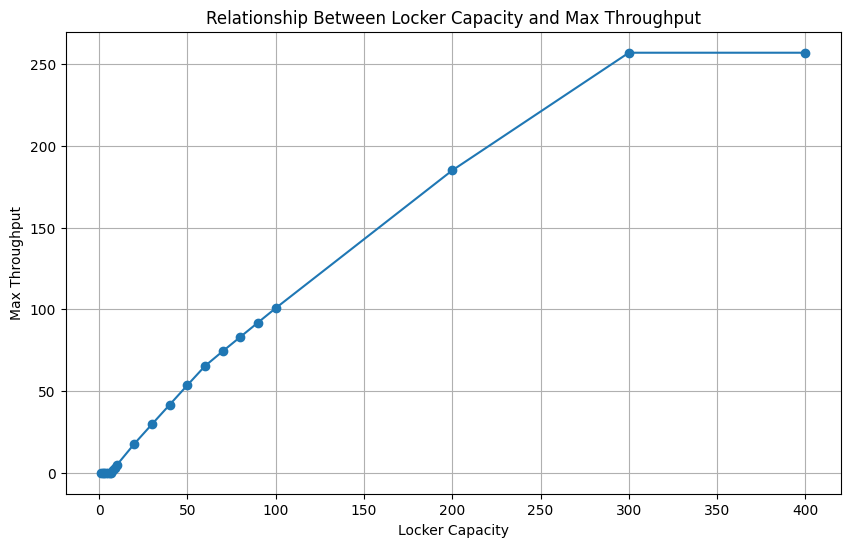

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(capacities, throughputs, marker='o')
plt.xlabel('Locker Capacity')
plt.ylabel('Max Throughput')
plt.title('Relationship Between Locker Capacity and Max Throughput')
plt.grid(True)
plt.show()

# Extended Model Implentation

In [17]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np

In [18]:
def run_model(T,S, C, p, e, d):
    model = gp.Model('ExtendedAmazonLockerOptimization')

    # Decision Variables

    # x = the number of slots to reserve for shipoption s on day t
    x = model.addVars(S, T, vtype=GRB.CONTINUOUS, name="x")
    
    # y = the number of packages accepted for arrival for ship options s on day t
    y = model.addVars(S, T, vtype=GRB.CONTINUOUS, name="y")

    # Objective Function (A.1)
    model.setObjective(gp.quicksum(y[s, t] for s in range(S) for t in range(T)), GRB.MAXIMIZE)

    # Constraint (A.2): Ensure locker capacity is not violated
    for t in range(T):
        model.addConstr(
            gp.quicksum(p[s][v][t] * y[s, v] for s in range(S) for v in range(t+1)) +
            gp.quicksum(p[s][v][t] * e[s][v] for s in range(S) for v in range(-6, 1)) <= C
        )

    # Constraint (A.3): Number of packages accepted must be less than or equal to the demand
    for s in range(S):
        for t in range(T):
            model.addConstr(y[s, t] <= d[s][t])

    # Constraint (A.4): Relationship between number of packages accepted and slots reserved
    for s in range(S):
        for t in range(T):
            model.addConstr(
                gp.quicksum(p[s][v][t] * y[s, v] for v in range(t+1)) +
                gp.quicksum(p[s][v][t] * e[s][v] for v in range(-6, 1)) == x[s, t]
            )

    # Constraint (A.5): Non-negativity of decision variables
    for s in range(S):
        for t in range(T):
            model.addConstr(x[s, t] >= 0)
            model.addConstr(y[s, t] >= 0)

    model.optimize()
    
    return model

In [19]:
capacities = [1,2,3,4,5,6,7,8,9,10, 20, 30, 40, 50, 60 ,70, 80 ,90, 100, 200, 300, 400]

results = {}

# Generate parameters using distributions
np.random.seed(42)  

# Parameters
T = 77  # Planning horizon (hours)
S = 4   # Number of shipping options (standard, two-day, one-day, same-day)

# Generate random dwell time probabilities
p_standard = [np.clip(np.random.normal(1.1, 0.2, T), 0, None).tolist() for _ in range(-6, T)]
p_two_day = [np.clip(np.random.normal(0.75, 0.1, T), 0, None).tolist() for _ in range(-6, T)]
p_one_day = [np.clip(np.random.normal(0.65, 0.1, T), 0, None).tolist() for _ in range(-6, T)]
p_same_day = [np.clip(np.random.normal(0.55, 0.1, T), 0, None).tolist() for _ in range(-6, T)]
p = [p_standard, p_two_day, p_one_day, p_same_day]

# Generate random initial packages in locker at the end of day 0
e_standard = np.random.randint(0, 2, size=T).tolist()
e_two_day = np.random.randint(0, 2, size=T).tolist()
e_one_day = np.random.randint(0, 2, size=T).tolist()
e_same_day = np.random.randint(0, 2, size=T).tolist()
e = [e_standard, e_two_day, e_one_day, e_same_day]

# Generate random package demand forecast
ratio_of_standard = 0.33
ratio_of_two_day = 0.264
ratio_of_one_day = 0.142
ratio_of_same_day = 0.264

num_packages_delivered = np.round(30*7/77)
rate_standard = num_packages_delivered*ratio_of_standard  # Average rate for standard shipping
rate_two_day =  num_packages_delivered*ratio_of_two_day # Average rate for two-day shipping
rate_one_day = num_packages_delivered*ratio_of_one_day # Average rate for one-day shipping
rate_same_day = num_packages_delivered*ratio_of_same_day # Average rate for same-day shipping

d_standard = np.random.poisson(rate_standard, size=T).tolist()
d_two_day = np.random.poisson(rate_two_day, size=T).tolist()
d_one_day = np.random.poisson(rate_one_day, size=T).tolist()
d_same_day = np.random.poisson(rate_same_day, size=T).tolist()
d = [d_standard, d_two_day, d_one_day, d_same_day]

In [20]:
throughputs = []
for C in capacities:
    try:
        result = run_model(T, S, C, p, e, d)
        results[C] = result
        throughputs.append(result.ObjVal)
        print(f"Locker capacity: {C}, Objective value: {result.ObjVal}")
    except:
        throughputs.append(0)

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1309 rows, 616 columns and 25256 nonzeros
Model fingerprint: 0x31bc54f7
Coefficient statistics:
  Matrix range     [2e-01, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 9e+00]
Presolve removed 1232 rows and 450 columns
Presolve time: 0.01s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Infeasible or unbounded model
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1309 rows, 616 columns and 25256 nonzeros
Model fingerprint: 0x112d374b
Coeffic

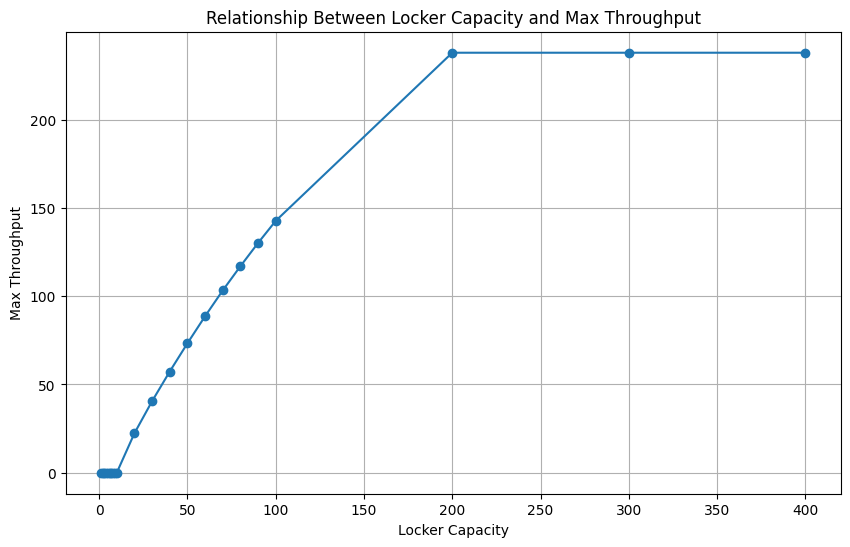

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(capacities, throughputs, marker='o')
plt.xlabel('Locker Capacity')
plt.ylabel('Max Throughput')
plt.title('Relationship Between Locker Capacity and Max Throughput')
plt.grid(True)
plt.show()